In [18]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00


In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
warnings.filterwarnings("ignore")

In [44]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('store5.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.fillna(method='ffill')

Saving store5.csv to store5 (2).csv


In [43]:
# Cek missing values
print(data.isnull().sum())

# Drop atau impute missing values
df = data.dropna()

df.head()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
dcoilwtico     33
dtype: int64


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
33,3234,2013-01-02,5,AUTOMOTIVE,6.0,0,93.14
34,3235,2013-01-02,5,BABY CARE,0.0,0,93.14
35,3236,2013-01-02,5,BEAUTY,7.0,0,93.14
36,3237,2013-01-02,5,BEVERAGES,947.0,0,93.14
37,3238,2013-01-02,5,BOOKS,0.0,0,93.14


In [45]:
cols_drop = ["id","store_nbr","dcoilwtico"]
df = df.drop(cols_drop,axis=1)

In [47]:
df["date"] = pd.to_datetime(df["date"],format="%Y-%m-%d")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55539 entries, 33 to 55571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         55539 non-null  datetime64[ns]
 1   family       55539 non-null  object        
 2   sales        55539 non-null  float64       
 3   onpromotion  55539 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [48]:
def filter_family(df: pd.DataFrame,family:str) -> pd.DataFrame:
    filtered_df = df[df["family"]==family].reset_index(drop=True)
    return filtered_df

In [49]:
def adfuller_test(df : pd.Series, p: int) -> None:
    if p == 0:
        result = adfuller(df.dropna())
        print("No Differencing")
        print(f"p-value : {result[1]}")
    else:
        diff_df = df.copy()
        for i in range(p + 1):
            if i == 0:
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")
            else:
                diff_df = diff_df.diff().dropna().reset_index(drop=True)
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")

In [51]:
df_lingerie = filter_family(df,"LINGERIE")
df_lingerie.head()

,date,family,sales,onpromotion
0,2013-01-02,LINGERIE,44.0,0
1,2013-01-03,LINGERIE,36.0,0
2,2013-01-04,LINGERIE,23.0,0
3,2013-01-05,LINGERIE,43.0,0
4,2013-01-06,LINGERIE,94.0,0


<Axes: xlabel='date'>

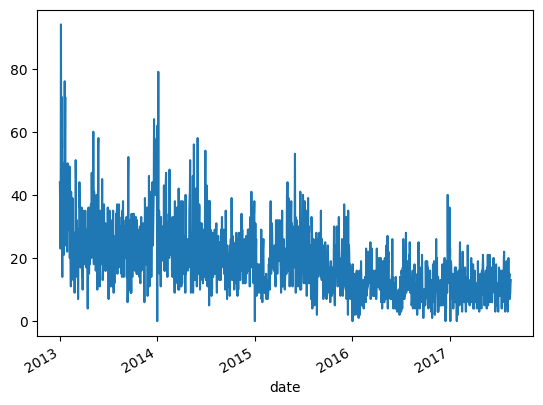

In [52]:
df_lingerie.set_index("date").sales.plot()

<Axes: xlabel='date'>

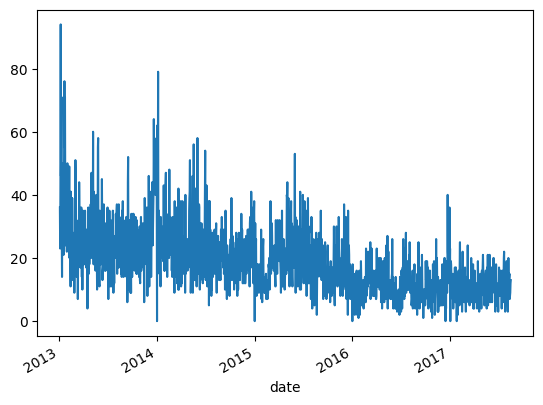

In [54]:
df_lingerie.iloc[1:,:].reset_index(drop=True).set_index("date").sales.plot()

<Axes: xlabel='date'>

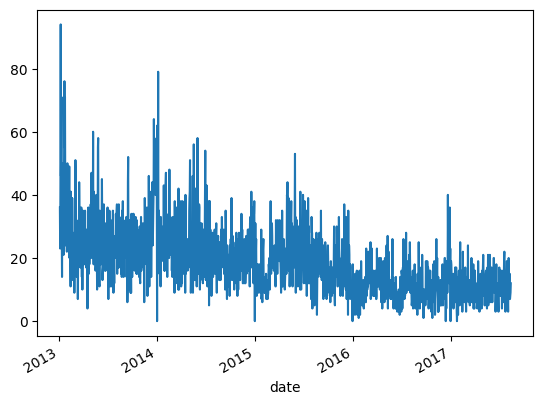

In [55]:
df_lingerie = df_lingerie.iloc[1:-1,:].reset_index(drop=True)
df_lingerie.set_index("date").sales.plot()

<Axes: xlabel='date'>

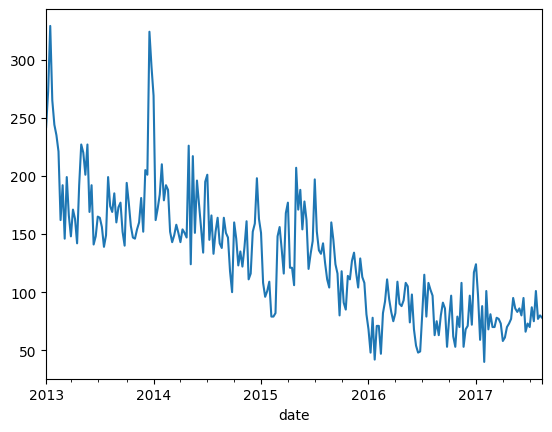

In [56]:
df_lingerie.set_index("date").sales.resample("W-MON").sum().plot()

In [57]:

df_lingerie = df_lingerie.set_index("date").sales.resample("W-MON").sum()
df_lingerie = np.log(df_lingerie)
df_lingerie.head()


date
2013-01-07    5.488938
2013-01-14    5.609472
2013-01-21    5.796058
2013-01-28    5.579730
2013-02-04    5.497168
Freq: W-MON, Name: sales, dtype: float64

In [58]:
df_lingeriee.indexlingerieate_range(start=dlingerierie.index.min(), end=lingerieerie.index.max(), freq='W-MON')

In [59]:
adfuller_test(df_lingerie,4)

Differencing level 0
p-value : 0.6068813814059081
Differencing level 1
p-value : 3.6227242368867696e-10
Differencing level 2
p-value : 1.9646047755873827e-14
Differencing level 3
p-value : 1.8296763842097368e-13
Differencing level 4
p-value : 7.209374971659936e-18


<Axes: >

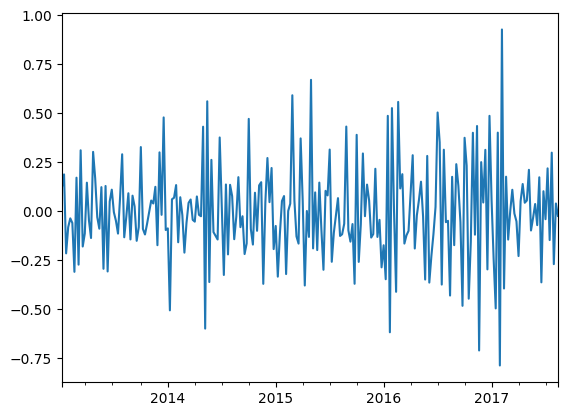

In [61]:
df_lingerie.diff().dropna().plot()

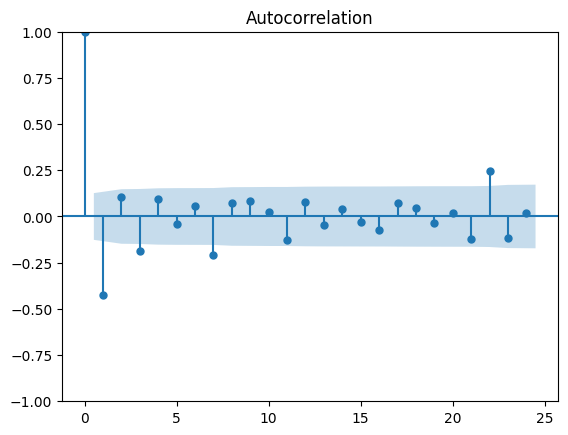

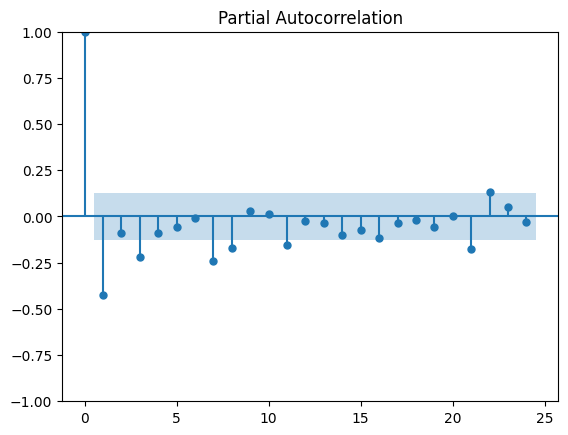

In [65]:
plot_acf(df_lingerie.diff().dropna());
plot_pacf(df_lingerie.diff().dropna());

Arima

In [68]:
train_date = int(len(df_lingerie)*0.98)
train_date

236

In [69]:
df_lingerie.iloc[:train_date]

2013-01-07    5.488938
2013-01-14    5.609472
2013-01-21    5.796058
2013-01-28    5.579730
2013-02-04    5.497168
                ...   
2017-06-12    4.553877
2017-06-19    4.189655
2017-06-26    4.290459
2017-07-03    4.248495
2017-07-10    4.465908
Freq: W-MON, Name: sales, Length: 236, dtype: float64

In [71]:
train_data = df_lingerie.iloc[:train_date]
test_data = df_lingerie.iloc[train_date:]

In [72]:
arima_model_1  = ARIMA(train_data, order=(3,1,1))
model_1 = arima_model_1.fit()

print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  236
Model:                 ARIMA(3, 1, 1)   Log Likelihood                  29.486
Date:                Wed, 26 Jun 2024   AIC                            -48.973
Time:                        23:40:26   BIC                            -31.675
Sample:                    01-07-2013   HQIC                           -41.999
                         - 07-10-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3424      0.076      4.492      0.000       0.193       0.492
ar.L2          0.2056      0.070      2.932      0.003       0.068       0.343
ar.L3         -0.0895      0.070     -1.280      0.2

In [73]:
#predict train
train_pred = model_1.predict(start=train_data.index.min(), end=train_data.index.max(),typ="linear")
train_pred = pd.DataFrame(train_pred)
train_pred

,predicted_mean
2013-01-07,0.000000
2013-01-14,5.488938
2013-01-21,5.559097
2013-01-28,5.700081
2013-02-04,5.631075
...,...
2017-06-12,4.378883
2017-06-19,4.436533
2017-06-26,4.329844
2017-07-03,4.270329


In [76]:
predict_train = pd.merge(train_data,train_pred,left_index=True, right_index=True)

rmse_score = mse(np.exp(predict_train.sales), np.exp(predict_train.predicted_mean),squared=False)
print(f"{rmse_score}")

31.352772259350274


In [78]:
mape_train = mape(np.exp(predict_train.sales), np.exp(predict_train.predicted_mean)) * 100
print(f"Percent error {mape_train.round(2)}")

Percent error 17.65


In [79]:
test_pred = model_1.predict(start=test_data.index.min(), end=test_data.index.max(),typ="linear")
test_pred = pd.DataFrame(test_pred)
test_pred

,predicted_mean
2017-07-17,4.379245
2017-07-24,4.398015
2017-07-31,4.367179
2017-08-07,4.368231
2017-08-14,4.360574


In [80]:
predict_test = pd.merge(test_data,test_pred,left_index=True, right_index=True)
display(predict_test)


rmse_score = mse(np.exp(predict_test.sales), np.exp(predict_test.predicted_mean),squared=False)
print(f"{rmse_score}")

mape_test = mape(np.exp(predict_test.sales), np.exp(predict_test.predicted_mean)) * 100
print(f"Percent error {mape_test.round(2)}")

,sales,predicted_mean
2017-07-17,4.317488,4.379245
2017-07-24,4.615121,4.398015
2017-07-31,4.343805,4.367179
2017-08-07,4.382027,4.368231
2017-08-14,4.356709,4.360574


9.120812582356079
Percent error 6.0


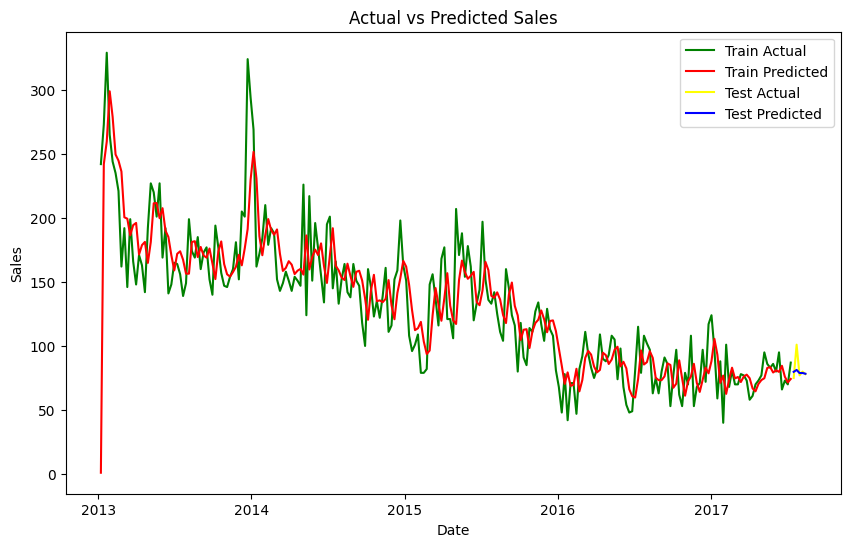

In [86]:
def plot_predictions(predict_train: pd.DataFrame, predict_test: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))


    plt.plot(predict_train.index, np.exp(predict_train['sales']), color='green', label='Train Actual')
    plt.plot(predict_train.index, np.exp(predict_train['predicted_mean']), color='red', label='Train Predicted')


    plt.plot(predict_test.index, np.exp(predict_test['sales']), color='yellow', label='Test Actual')
    plt.plot(predict_test.index, np.exp(predict_test['predicted_mean']), color='blue', label='Test Predicted')

    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Actual vs Predicted Sales')
    plt.legend()
    plt.show()
plot_predictions(predict_train, predict_test)